In [59]:
# Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt


In [60]:
def option_chains(ticker):
    """
    """
    asset = yf.Ticker(ticker)
    expirations = asset.options
    
    chains = pd.DataFrame()
    
    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(expiration)
        
        calls = opt.calls
        calls['optionType'] = "call"
        
        puts = opt.puts
        puts['optionType'] = "put"
        
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        chains = pd.concat([chains, chain])
    
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    
    return chains


In [63]:
ticker = "SPY"

spy_options_chain = option_chains(ticker)
calls = spy_options_chain[spy_options_chain["optionType"]=="call"]

expirations = set(calls.expiration)
print(sorted(expirations))

[Timestamp('2024-08-13 23:59:59'), Timestamp('2024-08-14 23:59:59'), Timestamp('2024-08-15 23:59:59'), Timestamp('2024-08-16 23:59:59'), Timestamp('2024-08-19 23:59:59'), Timestamp('2024-08-20 23:59:59'), Timestamp('2024-08-21 23:59:59'), Timestamp('2024-08-22 23:59:59'), Timestamp('2024-08-23 23:59:59'), Timestamp('2024-08-30 23:59:59'), Timestamp('2024-09-06 23:59:59'), Timestamp('2024-09-13 23:59:59'), Timestamp('2024-09-20 23:59:59'), Timestamp('2024-09-27 23:59:59'), Timestamp('2024-09-30 23:59:59'), Timestamp('2024-10-18 23:59:59'), Timestamp('2024-10-31 23:59:59'), Timestamp('2024-11-15 23:59:59'), Timestamp('2024-11-29 23:59:59'), Timestamp('2024-12-20 23:59:59'), Timestamp('2024-12-31 23:59:59'), Timestamp('2025-01-17 23:59:59'), Timestamp('2025-01-31 23:59:59'), Timestamp('2025-03-21 23:59:59'), Timestamp('2025-03-31 23:59:59'), Timestamp('2025-04-17 23:59:59'), Timestamp('2025-06-20 23:59:59'), Timestamp('2025-06-30 23:59:59'), Timestamp('2025-08-15 23:59:59'), Timestamp('20

Empty DataFrame
Columns: [contractSymbol, lastTradeDate, strike, lastPrice, bid, ask, change, percentChange, volume, openInterest, impliedVolatility, inTheMoney, contractSize, currency, optionType, expiration, daysToExpiration]
Index: []


[]

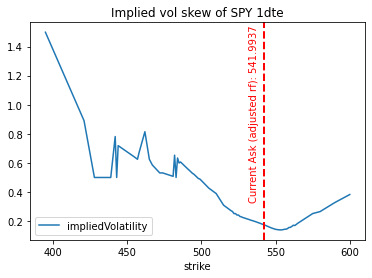

In [118]:
daysToExpiration = 3
oneDTE_calls = calls[calls['daysToExpiration'] == daysToExpiration]

# check to see if there are any cases of extreme outliers in implied vol
print(oneDTE_calls[oneDTE_calls["impliedVolatility"] < .000001])
oneDTE_calls = oneDTE_calls[oneDTE_calls['impliedVolatility'] > .000001]

current_ask_price_rf_adjusted = round(yf.Ticker(ticker).info['ask'] * (1 + (.039 * (daysToExpiration/365))),4)


#get 
ax = oneDTE_calls[['strike','impliedVolatility']].set_index('strike').plot(title=f"Implied vol skew of {ticker} 1dte")

#add in vertical line for previous market close price
ax.axvline(x=current_ask_price_rf_adjusted, color='red', linestyle='--', linewidth=2,)
ax.text(current_ask_price_rf_adjusted-10, ax.get_ylim()[1]*0.6, f'Current Ask (adjusted rf): {current_ask_price_rf_adjusted}', 
        rotation=90, verticalalignment='center', horizontalalignment='left', color='red')
ax.plot()


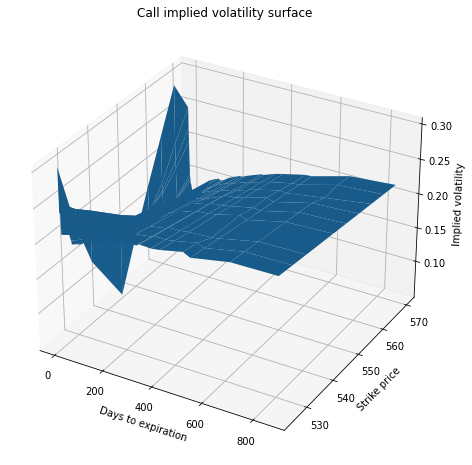

In [103]:
# pivot the dataframe
filteredCalls = calls[calls['impliedVolatility'] > 0.001]

surface = (
    filteredCalls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# create the figure object
fig = plt.figure(figsize=(10, 8))

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Call implied volatility surface')

# plot
ax.plot_surface(X, Y, z)
